# cbrLearn Agent

Steps:
1. [x] Clean Repo -> only top 30 policies and only last architecture (RepoCleanup Notebook)
2. [x] Collect image data of game for NN (Learning Agent Notebook)
3. [x] Image Augmentation (Learning Agent Notebook)
4. [x] Train NN {sig and soft} (Learning Agent Notebook)
5. [x] Evaluate NN -> export plots for Thesis(Learning Agent Notebook)

# Load Dependencies

In [1]:
from __future__ import division

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import numpy as np
import gym

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, Dropout, MaxPooling2D
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import normalize

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


import json
import matplotlib.pyplot as plt

from rl.callbacks import WandbLogger

import os

import import_ipynb

from cbrUtil import AtariProcessor, AtariProcessorCapture

import cv2
import time
import timeout_decorator

import random
import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


importing Jupyter notebook from cbrUtil.ipynb


## Clean Repo

In [2]:
import timeout_decorator
class LearnAgent():
    """
    Purpose of this agent is to clean up the ModelRepo.
    
    Folders that are checked:
    - /Policy/ -> Limit of 30 Policies
    - /Architecture -> Keeps the newest architecture
    
    Parameters:
    -----------

    env_name - str
        environment name of the target gameplay task
    """
    def __init__(self,env_name):
        """
        Inits the cleaning agent
        Parameters:
        -----------

        env_name - str
            environment name of the target gameplay task
        """
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        np.random.seed(123)
        self.env.seed(123)
        self.nb_actions = self.env.action_space.n
        self.WINDOW_LENGTH = 4
        self.INPUT_SHAPE = (84,84)
        self.model = None
        self.memory = None
        self.processor = None
        self.policy = None
        self.dqn = None
        self.history = None
        self.path = './KC/ModelRepo/Atari_' + self.env_name
        self.limit = 30
        self.path_to_architecture = self.path+'/Architecture/'
        self.path_to_policy = self.path+'/Policy/'
        
        self.printInitialization()
        
        self.buildModel()
        self.configAgent()
        self.compileAgent()
        
        self.rewardRename()
        self.deletePolicy()
        self.deleteArchitecture()
        self.undoRenaming()
        
        self.cleaningDone()
        
    def cleaningDone(self):
        """
        Sends message when learning is done.
        """
        print(f"Cleaned Model Repo successfully for: {self.env_name}")
        
    def printInitialization(self):
        """
        Show current status of the model repository.
        """
        print(f"Env:{self.env_name}\n"+
              f"nb_actions:{self.nb_actions}\n"+
              f"Path:{self.path}")
        
    def buildModel(self):
        """
        Builds keras model for testing the agent.
        """
        input_shape = (self.WINDOW_LENGTH,) + self.INPUT_SHAPE
        model = Sequential()
        if K.common.image_dim_ordering() == 'tf':
            # (width, height, channels)
            model.add(Permute((2, 3, 1), input_shape=input_shape))
        elif K.image_dim_ordering() == 'th':
            # (channels, width, height)
            model.add(Permute((1, 2, 3), input_shape=input_shape))
        else:
            raise RuntimeError('Unknown image_dim_ordering.')
        model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(self.nb_actions))
        model.add(Activation('linear'))
        #print(model.summary())
        self.model=model
        #return model
    
    def configAgent(self):
        """
        Configs the agent. Q-Injection is always False.
        """
        self.memory = SequentialMemory(limit=1000000, 
                                  window_length=self.WINDOW_LENGTH)
        
        self.processor = AtariProcessor()
        
        self.policy = LinearAnnealedPolicy(EpsGreedyQPolicy(action_size=self.nb_actions,
                                                            q_Injection=False), 
                                      attr='eps', 
                                      value_max=1., 
                                      value_min=.1, 
                                      value_test=.05,
                                      nb_steps=1000000)
    def compileAgent(self):
        """
        Compiles the agent.
        """
        self.dqn = DQNAgent(model=self.model, 
                            nb_actions=self.nb_actions, 
                            policy=self.policy, 
                            memory=self.memory,
                            processor=self.processor, 
                            nb_steps_warmup=50000, 
                            gamma=.99, 
                            target_model_update=10000,
                            train_interval=4, delta_clip=1.)

        self.dqn.compile(Adam(lr=.00025), metrics=['mae'])
        
        
    @timeout_decorator.timeout(10)
    def testAgent(self, weights_filepath,verbose=0):
        """
        Tests the learned policy for one episode.
        """
        self.dqn.load_weights(weights_filepath)
        self.history = self.dqn.test(self.env, 
                                nb_episodes=1, 
                                visualize=False,
                                verbose=verbose) #0 = nothing to show
     
    
    def testAgentNormal(self, weights_filepath,
                        verbose=1,
                        visualize=False):
        """
        Tests the learned policy for five episodes.
        """
        self.dqn.load_weights(self.path_to_policy+weights_filepath)
        self.history = self.dqn.test(self.env, 
                                nb_episodes=5, 
                                visualize=visualize,
                                verbose=verbose) #0 = nothing to show
        

    def rewardRename(self):
        """
        Helper Function for renaming the policies.
        """
        print("Test policies for max reward...")
        for policy in os.listdir(self.path_to_policy):
            all_policy = len(os.listdir(self.path_to_policy))
            i = 1
            if 'ipynb_checkpoints' in policy:
                pass
            elif 'DS_Store' in policy:
                pass
            else:
                if 'reward' in policy:
                    pass
                else:
                    old_policy_path = self.path_to_policy+policy
                    reward = 0
                    try:
                        self.testAgent(old_policy_path)
                        reward = self.history.history['episode_reward'][0]
                        reward = int(reward)
                        i=i+1
                    except Exception:
                         reward = 0
                    p = policy.split(".")
                    policy_new = p[0] + f'_reward_{reward}.' + p[1]
                    new_policy_path = self.path_to_policy+policy_new
                    #print(f"New policy: {new_policy_path}")

                    os.rename(old_policy_path,new_policy_path)
        print("--------")       
        
    def extractReward(self,policy):
        """
        Sorts the policy by received reward'
        """
        reward = 0
        policy =  policy
        policy = policy.split(sep='.')
        policy = policy[0].split(sep='_')
        reward = int(policy[-1])
        return reward
    
    def deletePolicy(self):
        """
        This functions cleans the model repository. The policies with 
        the least rewards is deleted.
        """
        repo_list = []
        for policy in os.listdir(self.path_to_policy): 
            #testRepo = self.path
            if 'ipynb_checkpoints' in policy:
                pass
            elif 'DS_Store' in policy:
                pass
            else:
                repo_list.append(policy)
                #print(f"Reward: {extractReward(policy)}")

        repo_list.sort(key=self.extractReward,reverse=True)
        deleted_policies = 0
        if len(repo_list)>self.limit:
            for del_policy in repo_list[self.limit:]:
                print(self.path_to_policy+del_policy)
                deleted_policies+=1
                os.remove(self.path_to_policy+del_policy)
        else:
            print("Nothing to delete")
        print(f"Deleted {deleted_policies} policies.")
        print("--------")
        
    def deleteArchitecture(self):
        """
        This functions cleans the model repository. The last 
        architectures are kept (FIFO principle).
        """
        architectures = []
        for architecture in os.listdir(self.path_to_architecture):
            if 'DS_Store' in architecture:
                pass
            elif 'ipynb_checkpoints' in architecture:
                pass
            else:
                architectures.append(architecture)
                
                architectures.sort(key=self.sortStartEnd,
                                   reverse=False)
                
                architectures.sort(key=self.getTimeArchitecture,
                                   reverse=True)
        i = 0
        if len(os.listdir(self.path_to_architecture)) >= 2:

            for archicteture_to_delte in architectures[1:]:
                print(f"{self.path_to_architecture+archicteture_to_delte}")
                os.remove(self.path_to_architecture+archicteture_to_delte)
                i+=1
        else:
            print("Nothing to delete")
        print(f"Deleted {i} architecture(s)")
        print("--------")
    
    def getTimeArchitecture(self,architecture):
        """
        Sorts architecture repo by time'
        """
        architecture = architecture.split(sep='_')
        time = architecture[1]
        return time
    
    def sortStartEnd(self,architecture):
        """
        Sorts architecture repo by str 'start' or 'end'
        """
        architecture = architecture.split(sep='_')
        architecture = architecture[2]
        architecture = architecture.split(sep='.')
        length = len(architecture[0])
        return length
    
    def renamingDefault(self,src_name):
        """
        Create default naming string
        """
        split_word = src_name.split(sep="_")
        target_name = (split_word[0]+
                       '_'+split_word[1]+
                       '_'+split_word[2]+
                       '_'+split_word[3]+
                       '.h5f')
        return target_name
    
    def undoRenaming(self):
        """
        Rename policies to default.
        """
        for policy in os.listdir(self.path_to_policy):
            if 'ipynb_checkpoints' in policy:
                pass
            else:
                if 'reward' in policy:
                    old_policy_path = self.path_to_policy+policy
                    new_policy = self.renamingDefault(policy)
                    new_policy_path = self.path_to_policy+new_policy
                    os.rename(old_policy_path,new_policy_path)
                else:
                    pass
        print(f"Renamed Policies.")

In [3]:
ENV_NAME = 'MsPacman-v0'
agent = LearnAgent(ENV_NAME)

## Collect image data of game for NN ->ImageCollectorAgent
### Recording
### Augemtation

In [7]:
class ImageCollectorAgent():
    """
    This agent collects images for the current target gameplay task.
    Therefore, the agent plays the environment with the learned 
    policies and collects 5000 images. After image collection, the 
    agent augments the 5000 images to get 25000 images.
    """
    def __init__(self,env_name):
        """
        Initializes the agent and controles the flow.
        
        Parameters:
        -----------
        env_name - str
            current target gameplay task
        """
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        np.random.seed(123)
        self.env.seed(123)
        self.nb_actions = self.env.action_space.n
        self.printInitialization()
        self.WINDOW_LENGTH = 4
        self.INPUT_SHAPE = (84,84)
        self.model = None
        self.memory = None
        self.processor = None
        self.policy = None
        self.dqn = None
        self.history = None
        self.save_img = True
        self.img_folder_limit = 5000
        self.limitAugs = 25000.0
        
        self.path = './KC/ModelRepo/Atari_' + self.env_name
        self.path_to_architecture = self.path+'/Architecture/'
        self.path_to_policy = self.path+'/Policy/'
        self.path_to_gameplay = self.path+'/GamePlay/'
        
        self.buildModel()
        self.configAgent()
        self.compileAgent()
        self.recordImg()
        self.img_augemtation()
        
    def printInitialization(self):
        """
        Shows current status of the environment.
        """
        print(f"Env:{self.env_name}\n"+
              f"nb_actions:{self.nb_actions}")
        
    def buildModel(self):
        """
        Builds the keras Model.
        """
        input_shape = (self.WINDOW_LENGTH,) + self.INPUT_SHAPE
        model = Sequential()
        if K.common.image_dim_ordering() == 'tf':
            # (width, height, channels)
            model.add(Permute((2, 3, 1), input_shape=input_shape))
        elif K.image_dim_ordering() == 'th':
            # (channels, width, height)
            model.add(Permute((1, 2, 3), input_shape=input_shape))
        else:
            raise RuntimeError('Unknown image_dim_ordering.')
        model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(self.nb_actions))
        model.add(Activation('linear'))
        self.model=model
    
    def configAgent(self):
        """
        Configures the DRL agent
        """
        self.memory = SequentialMemory(limit=1000000, 
                                  window_length=self.WINDOW_LENGTH)
        
        self.processor = AtariProcessorCapture(self.path_to_gameplay,  
                                               self.env_name)
        
        self.policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                                      attr='eps', 
                                      value_max=1., 
                                      value_min=.1, 
                                      value_test=.05,
                                      nb_steps=1000000)
    def compileAgent(self):
        """
        Compiles the DRL agent
        """
        self.dqn = DQNAgent(model=self.model, 
                            nb_actions=self.nb_actions, 
                            policy=self.policy, 
                            memory=self.memory,
                            processor=self.processor, 
                            nb_steps_warmup=50000, 
                            gamma=.99, 
                            target_model_update=10000,
                            train_interval=4, delta_clip=1.)

        self.dqn.compile(Adam(lr=.00025), metrics=['mae'])
        
        
    @timeout_decorator.timeout(10)
    def testAgentImg(self, weights_filepath):
        """
        Runs the DRL agent for one episode inside the environment.
        """
        self.dqn.load_weights(weights_filepath)
        self.history = self.dqn.test(self.env, 
                                nb_episodes=1, 
                                visualize=False,
                                verbose=0) #0 = nothing to show
            
    
    def recordImg(self):
        """
        Records images from current gameplay.
        """
        img_files_in_folder = len(os.listdir(self.path_to_gameplay))
        
        print(f"Found {img_files_in_folder} images.\nImage Limit:{self.img_folder_limit}")
        print("Start recording...")
        
        while img_files_in_folder<self.img_folder_limit:
            for policy in os.listdir(self.path_to_policy):
                test_policy = self.path_to_policy + policy
                try:
                    self.history = self.testAgentImg(test_policy)
                except Exception:
                    #print("STOP") 
                    pass
                #print("")
            img_files_in_folder = len(os.listdir(self.path_to_gameplay))
            print(img_files_in_folder)
            
    def getNumsOfAugs(self):
        """
        Helper function, that calculates the number of 
        image augemtation.
        """
        nums = self.limitAugs/len(os.listdir(self.path_to_gameplay))
        nums = int(nums)+1
        return nums
    
    def img_augemtation(self):
        """
        This function augments the recorded images.
        """
        gen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.15,
                             zoom_range=0.1,
                             channel_shift_range=10.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest',
                                rescale=1./255)


        print(f"Augment folder: {self.path_to_gameplay}")
        nums_of_augs = self.getNumsOfAugs()
        print(f"Nums of Augs: {nums_of_augs}")
        i = 0
        for img in os.listdir(self.path_to_gameplay):
            folder_size = len(os.listdir(self.path_to_gameplay))

            if i==0:
                print(f"Folder:{self.path_to_gameplay}")
                print(f"Folder Size: {folder_size}")
            else:
                pass

            if folder_size < 25000:
                try:
                    img_path = os.path.join(self.path_to_gameplay,img)
                    img = np.expand_dims(cv2.imread(img_path),0)
                    for i in range(nums_of_augs):
                        prefix = "aug_pic_"
                        aug_iter = gen.flow(img,
                                            save_to_dir=self.path_to_gameplay,
                                            save_prefix=prefix+str(i))
                        aug_iter[0]      
                except Exception as e:
                    print("Exception")
                #folder_size = len(os.listdir(path))
            else:
                print("Folder Size over 25000")
                break
            i=i+1
        print("------------------")
        print("Augmentation done")

In [8]:
ENV_NAME = 'Seaquest-v0'
agentImageCollect = ImageCollectorAgent(ENV_NAME)

## Train NN {sig and soft}

In [12]:
class PrepareClassifierAgent():
    
    """
    This class prepares the classifier agent.
    class labels in alphabetic order of Model Repository.
    """
    
    def __init__(self):
        """
        Initializes the agent and runs the process.
        """
        self.path_to_games = './KC/ModelRepo/'
        self.categories = self.getCategories()
        self.categories_folder = self.getCategoriesFolder()
        self.IMG_SIZE = 84
        self.path_to_classifier_data = './KC/CNN/'
        
        self.training_data = []
        
        self.save_time = str(int(time.time()))
        
        self.create_training_data()
        
        self.trainingDataSanityCheck()
        
        self.shuffleTrainingData()
        
        self.x = []
        self.y = []
        
        self.x_array = None
        self.y_array = None
        
        
        self.saveDataArray()
        self.saveDataPickle()
        
        print("Data Preparation Done!")

    
    def getCategories(self):
        """
        retrieves all categories from the model repository.
        """
        categories = []
        for folder in os.listdir('./KC/ModelRepo/'):
            if 'Atari' in folder:
                #print(folder)
                categories.append(folder)
        categories.sort()
        return categories
    
    def getCategoriesFolder(self):
        """
        retrieves all category folders from the model repository.
        """
        categories_folder = []
        for category in self.categories:
            cat_folder = self.path_to_games+category+'/GamePlay/'
            categories_folder.append(cat_folder)
        return categories_folder
    
    
    def create_training_data(self):
        """
        extracts all images from the environments folder within the
        model repository.
        """
        for folder in self.categories_folder:
            class_num = self.categories_folder.index(folder)
            print(f"Class: {class_num}")
            for img in os.listdir(folder):
                try:
                    img_array = cv2.imread(os.path.join(folder,img),
                                           cv2.IMREAD_GRAYSCALE)
                    new_array = cv2.resize(img_array,
                                           (self.IMG_SIZE,self.IMG_SIZE))
                    
                    self.training_data.append([new_array,class_num])
                except Exception as e:
                    pass
                
    def trainingDataSanityCheck(self):
        """
        Prints some statistics.
        """
        print(f"Counted: {len(self.training_data)} images")
    
    def shuffleTrainingData(self):
        """
        shuffles training data. important step in order to avoid a 
        biased neural network.
        """
        print("Shuffling Data")
        random.shuffle(self.training_data)
        
        for sample in self.training_data[0:10]:
            print(sample[1])
        
    def saveDataArray(self):
        """
        Saves to data and the labels to an array in order to store it
        inside a pickle file.
        """
        for features,label in self.training_data:
            self.x.append(features)
            self.y.append(label)

        #rgb -> last number is 3 (for covnet)   
        #last number for gray -> 3 for rgb
        self.x_array = np.array(self.x).reshape(-1,
                                                self.IMG_SIZE,
                                                self.IMG_SIZE,
                                                1) 
    
        self.y_array = np.array(self.y)
        
    def saveDataPickle(self):
        """
        This function pickles the data and saves it inside the KC.
        """
        print("Saving data to pickle...")
        save_file_x = (self.path_to_classifier_data+
                       self.save_time+
                       "_x_atari.pickle")
        save_file_y = (self.path_to_classifier_data+
                       self.save_time+
                       "_y_atari.pickle")
        
        pickel_out = open(save_file_x,"wb")
        pickle.dump(self.x_array,pickel_out)
        pickel_out.close

        pickel_out = open(save_file_y,"wb")
        pickle.dump(self.y_array,pickel_out)
        pickel_out.close
        print(f"Saving time: {self.save_time}")

In [13]:
agClassify = PrepareClassifierAgent()

Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Counted: 125957 images
Shuffling Data
3
0
2
3
1
4
1
1
0
1
Saving data to pickle...
Saving time: 1580678652
Data Preparation Done!


In [14]:
class TrainClassificationAgent():
    """
    This agent trains the image classifier.
    Could be beneficial to check this agent in future work in order to
    build a more powerful classification agent. For example, one could
    try to tune hyperparameters (optimizer, learning rate, loss, ...)
    """
    
    def __init__(self):
        """
        Initializes the agent and runs the process.
        """
        self.IMG_SIZE = 84
        #specifies where the neural network models are stored
        self.path_to_classifier_data = './KC/CNN/'
        self.X = None
        self.y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.model_sig = None
        self.model_soft = None
        self.num_classes = None
        self.hist_sig = None
        self.hist_soft = None
        self.save_time = str(int(time.time()))
        
        #runs the entire training process.
        self.cleanClassificationFolder()
        self.getPickle()
        self.createTrainTestSplit()
        self.normalizeTrainTestData()
        self.getNumClasses()
        self.nnArchitectureSig()
        self.nnArchitectureSoft()
        self.compileModelSig()
        self.compileModelSoft()
        self.fitModelSig()
        self.fitModelSoft()
        self.showModelSigData()
        self.showModelSoftData()
        self.saveSigModel()
        self.saveSoftModel()
        print("Trained models and saved to directory.")
        
    def cleanClassificationFolder(self):
        """
        Clean previous files in order to get the newest file.
        """
        print("Start cleaning the folder...")
        pickle_archive=[]
        for pickle in os.listdir(self.path_to_classifier_data):
            if 'pickle' in pickle:
                pickle_archive.append(pickle)

        pickle_archive.sort()
        if len(pickle_archive)>2:
            for pickle in pickle_archive[:-2]:
                print(f"Moved {pickle} to archive.")
                pickle_old = self.path_to_classifier_data+pickle
                pickle_new = self.path_to_classifier_data+'Archive/Pickle/'+pickle
                os.rename(src=pickle_old,dst=pickle_new)
                
        model_archive=[]
        for model in os.listdir(self.path_to_classifier_data):
            if 'h5' in model:
                model_archive.append(model)

        model_archive.sort()
        if len(model_archive)>2:
            for model in model_archive[:-2]:
                print(f"Moved {model} to archive.")
                model_old = self.path_to_classifier_data+model
                model_new = self.path_to_classifier_data+'Archive/Models/'+model
                os.rename(src=model_old,dst=model_new)
        print("Cleaned classification folder.")
        print("----------")
    
    def getPickle(self):
        """
        Retrieves current pickle file with image data and lables.
        """
        print("Loading current pickle files")
        for pickle_file in os.listdir(self.path_to_classifier_data):
            if 'pickle' in pickle_file:
                if 'x' in pickle_file:
                    open_file_x = self.path_to_classifier_data+pickle_file
                else:
                    open_file_y = self.path_to_classifier_data+pickle_file
        
        pickle_in = open(open_file_x,"rb")
        self.X = pickle.load(pickle_in)

        pickle_in = open(open_file_y,"rb")
        self.y = pickle.load(pickle_in)
        print("Loaded Pickle")
        print("-------")
        
    def createTrainTestSplit(self):
        (self.x_train, 
         self.x_test, 
         self.y_train, 
         self.y_test) = train_test_split(self.X,
                                         self.y,
                                         train_size=0.9)
        
        """
        Splits data for training and validation.
        """
        
        #print(f"Length of X_train: {len(self.x_train)}")
        #print(f"Length of X_test: {len(self.x_test)}")
        #print(f"Length of y_train: {len(self.y_train)}")
        #print(f"Length of y_test: {len(self.y_test)}")
        print(f"Sum: {len(self.x_train)+len(self.x_test)}")
        print("-------")
              
    def normalizeTrainTestData(self):
        """
        normalizes image data.
        """
        print("Normalizing data...")
        self.x_train = normalize(self.x_train,axis=1)
        self.x_test = normalize(self.x_test,axis=1)
        print("-------")
        
    def getNumClasses(self):
        """
        get the current number of classes inside the model repository.
        """
        number_classes = np.unique(self.y_train)
        self.num_classes = len(number_classes)
        print(f"Different Classes: {self.num_classes}")
        print("-------")
        
    def nnArchitectureSig(self):
        """
        Builds the neural network with the sigmoid layer.
        """
        #print("Creating CNN with sigmoid output")
        model = Sequential()
        model.add(Convolution2D(32, (8, 8), strides=(4, 4),input_shape=self.X.shape[1:]))
        model.add(Activation('relu'))

        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))

        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))

        model.add(Dense(self.num_classes))
        model.add(Activation("sigmoid"))
        self.model_sig = model
        #print("-------")
        
    def nnArchitectureSoft(self):
        """
        Builds the neural network with the softmax layer.
        """
        #print("Creating CNN with softmax output")
        model = Sequential()
        model.add(Convolution2D(32, (8, 8), strides=(4, 4),input_shape=self.X.shape[1:]))
        model.add(Activation('relu'))

        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))

        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))

        model.add(Dense(self.num_classes))
        model.add(Activation("softmax"))
        self.model_soft = model
        #print("-------")
        
    def compileModelSig(self):
        """
        Compiles the sigmoid neural network.
        """
        #print("Compile sigmoid model...")
        self.model_sig.compile(loss="sparse_categorical_crossentropy",
                              optimizer=Adam(lr=0.00001),
                            metrics=['accuracy'])
        #print("-------")
      
    def compileModelSoft(self):
        """
        Compiles the softmax neural network.
        """
        #print("Compile softmax model...")
        self.model_soft.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
        #print("-------")
    
    def fitModelSig(self):
        """
        Starts the training session for the sigmoid model.
        """
        print("Train sigmoid model with data...")
        self.hist_sig = self.model_sig.fit(self.x_train,
                                             self.y_train,
                                             batch_size=32,
                                             validation_split=0.1,
                                             epochs=5,
                                             verbose=0)
        print("-------")
    
    def fitModelSoft(self):
        """
        Starts the training session for the softmax model.
        """
        print("Train softmax model with data...")
        self.hist_soft = self.model_soft.fit(self.x_train,
                                             self.y_train,
                                             batch_size=32,
                                             validation_split=0.1,
                                             epochs=5,
                                             verbose=0)
        print("-------")
        
    def showModelSoftData(self):
        """
        Analyze data to see if the model was able to learn from the 
        data.
        """
        color_gray= '#979797'
        color_red = '#FF0000'
        title_acc = 'Model accuracy - Softmax_'+self.save_time
        # Plot training & validation accuracy values
        plt.plot(self.hist_soft.history['accuracy'],color=color_gray)
        plt.plot(self.hist_soft.history['val_accuracy'],color=color_red) #enable validation-split in model.fit()
        plt.title(title_acc)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        save_name =(self.path_to_classifier_data+
                    'Charts/'+
                    self.save_time+
                    '_softmax_accuracy.png')
        plt.savefig(save_name)
        plt.show()

        # Plot training & validation loss values
        title_loss = 'Model loss - Softmax_'+self.save_time
        plt.plot(self.hist_soft.history['loss'],color=color_gray)
        plt.plot(self.hist_soft.history['val_loss'],color=color_red)
        plt.title(title_loss)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        save_name =(self.path_to_classifier_data+
                    'Charts/'+
                    self.save_time+
                    '_softmax_loss.png')
        plt.savefig(save_name)
        plt.show()
        
    def showModelSigData(self):
        """
        Analyze data to see if the model was able to learn from the 
        data.
        """
        color_gray= '#979797'
        color_red = '#FF0000'
        title_acc = 'Model accuracy - Sigmoid_'+self.save_time
        plt.plot(self.hist_sig.history['accuracy'],color=color_gray)
        plt.plot(self.hist_sig.history['val_accuracy'],color=color_red) #enable validation-split in model.fit()
        plt.title(title_acc)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        save_name =(self.path_to_classifier_data+
                    'Charts/'+
                    self.save_time+
                    '_sigmoid_accuracy.png')
        plt.savefig(save_name)
        plt.show()

        # Plot training & validation loss values
        title_loss = 'Model loss - Sigmoid_'+self.save_time
        plt.plot(self.hist_sig.history['loss'],color=color_gray)
        plt.plot(self.hist_sig.history['val_loss'],color=color_red)
        plt.title(title_loss)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        save_name =(self.path_to_classifier_data+
                    'Charts/'+
                    self.save_time+
                    '_sigmoid_loss.png')
        plt.savefig(save_name)
        plt.show()
        
    def saveSigModel(self):
        """
        Saves the learned model inside the KC.
        """
        filename_sig = (self.path_to_classifier_data+
                    self.save_time+
                    '_Atari_sigmoid.h5')
        self.model_sig.save(filename_sig)

    def saveSoftModel(self):
        """
        Saves the learned model inside the KC.
        """
        filename_soft = (self.path_to_classifier_data+
                    self.save_time+
                    '_Atari_softmax.h5')
        self.model_soft.save(filename_soft)

Start cleaning the folder...
Cleaned classification folder.
----------
Loading current pickle files
Loaded Pickle
-------
Sum: 125957
-------
Normalizing data...
-------
Different Classes: 5
-------
Train sigmoid model with data...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
-------
Train softmax model with data...
-------


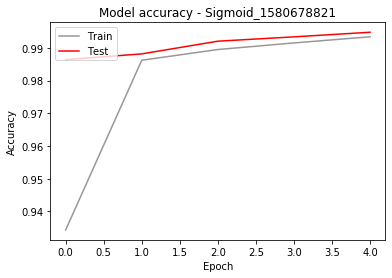

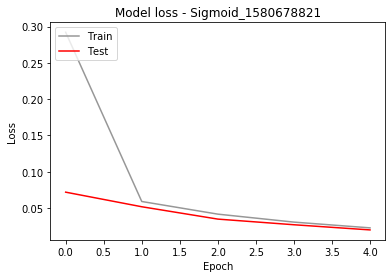

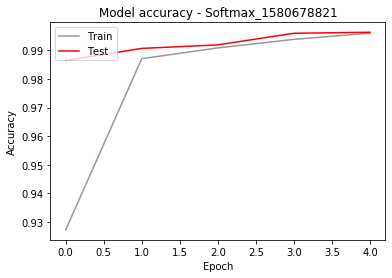

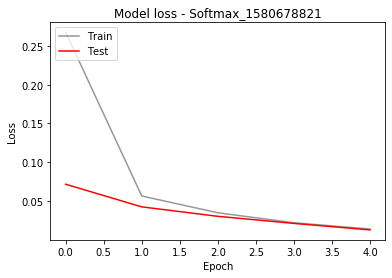

Trained models and saved to directory.


In [15]:
classificationAgent = TrainClassificationAgent()